1. Import dependencies for the project

In [24]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import *
from torch.utils.data import Dataset

import torchvision
import torchvision.models as models
from torchvision import transforms, datasets

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

dataset_root = "../datasets/chest_Xray/" # put your own path to the given directory images here.
batch_size = 128
target_size = (224,224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2. Data Loading and Modifications

In [15]:
# Get the transforms
def load_datasets():

    # Transforms for the image.
    transform = transforms.Compose([
                        transforms.Grayscale(),
                        transforms.Resize(target_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        nn.Flatten()
                ])

    # Define the image folder for each of the data set types
    trainset = torchvision.datasets.ImageFolder(
        root=dataset_root + 'train',
        transform=transform
    )
    validset = torchvision.datasets.ImageFolder(
        root=dataset_root + 'val',
        transform=transform
    )
    testset = torchvision.datasets.ImageFolder(
        root=dataset_root + 'test',
        transform=transform
    )


    # Define indexes and get the subset random sample of each.
    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=len(validset), shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)


    # Convert data to tensors. This could be made faster.
    x_test = []
    y_test = []
    for idx, (data, tar) in enumerate(test_dataloader):
        x_test = data.squeeze()
        y_test = tar.squeeze()

    x_train = []
    y_train = []
    for idx, (data, tar) in enumerate(train_dataloader):
        x_train = data.squeeze()
        y_train = tar.squeeze()
        
    x_test = torch.tensor(x_test, device=device)
    y_test = torch.tensor(y_test, device=device)
    x_train = torch.tensor(x_train, device=device)
    y_train = torch.tensor(y_train, device=device)
    return x_train, y_train, x_test, y_test

3. KNN

In [16]:
def knn(x_train, y_train, x_test, k, device, log_interval=100, log=True):

    # Get the amount of images, training images, and image size.
    num_images = x_test.shape[0]
    num_train = y_train.shape[0]
    img_size = x_test.shape[1]

    y_test = torch.zeros((num_images), device=device, dtype=torch.float)

    # For each of the images in the test set
    for test_index in range(0, num_images):

        # Get the image and calculate the distance to every item in the trainset
        test_image = x_test[test_index]
        distances = torch.norm(x_train - test_image, dim=1)

        # Get the top k indexes and get the most used index between them all
        indexes = torch.topk(distances, k, largest=False)[1]
        classes = torch.gather(y_train, 0, indexes)
        mode = int(torch.mode(classes)[0])

        # Save the test value in the index.
        y_test[test_index] = mode

        # Logging since with large sets it may be helpful
        if log:
            if test_index % log_interval == 0:
                print("Currently predicting at test_index = %d" % test_index)

    return y_test

4. Testing

In [17]:
print("Loading data from folders.")
x_train, y_train, x_test, y_test = load_datasets()
print("Loaded train and test with sizes: %s, %s" % (str(x_train.shape), str(x_test.shape)))

Loading data from folders.


/var/folders/w2/4ws264zn1856br7h43g6nb100000gn/T/ipykernel_6664/2891613063.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, device=device)
/var/folders/w2/4ws264zn1856br7h43g6nb100000gn/T/ipykernel_6664/2891613063.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, device=device)
/var/folders/w2/4ws264zn1856br7h43g6nb100000gn/T/ipykernel_6664/2891613063.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, device=device)


Loaded train and test with sizes: torch.Size([5216, 50176]), torch.Size([624, 50176])


/var/folders/w2/4ws264zn1856br7h43g6nb100000gn/T/ipykernel_6664/2891613063.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, device=device)


In [18]:
pred = knn(x_train, y_train, x_test, k=1, device=device)

Currently predicting at test_index = 0
Currently predicting at test_index = 100
Currently predicting at test_index = 200
Currently predicting at test_index = 300
Currently predicting at test_index = 400
Currently predicting at test_index = 500
Currently predicting at test_index = 600


In [19]:
correct = pred.eq(y_test.to(device).view_as(pred)).sum()
print("Correct predictions: %d/%d, Accuracy: %f" % (correct, y_test.shape[0], 100. * correct / y_test.shape[0]))

Correct predictions: 473/624, Accuracy: 75.801285


5. Hyperparameter Grid Search

In [20]:
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 25, 37, 49, int(np.floor(np.sqrt(x_train.shape[0]))), 200]

correct_vals = []

best_k = -1
best_correct = 0

for k in k_values:
    pred = knn(x_train, y_train, x_test, k=k, device=device, log=False)
    correct = pred.eq(y_test.view_as(pred)).sum()
    print("K = %d, Correct: %d, Accuracy: %.2f" % (k, correct, 100. * correct / y_test.shape[0]))

K = 1, Correct: 473, Accuracy: 75.80
K = 2, Correct: 498, Accuracy: 79.81
K = 3, Correct: 468, Accuracy: 75.00
K = 4, Correct: 488, Accuracy: 78.21
K = 5, Correct: 461, Accuracy: 73.88
K = 6, Correct: 475, Accuracy: 76.12
K = 7, Correct: 464, Accuracy: 74.36
K = 8, Correct: 474, Accuracy: 75.96
K = 9, Correct: 461, Accuracy: 73.88
K = 10, Correct: 469, Accuracy: 75.16
K = 13, Correct: 452, Accuracy: 72.44
K = 25, Correct: 449, Accuracy: 71.96
K = 37, Correct: 443, Accuracy: 70.99
K = 49, Correct: 439, Accuracy: 70.35
K = 72, Correct: 441, Accuracy: 70.67
K = 200, Correct: 432, Accuracy: 69.23


6. Init function to show confusion matrix and ROC curve

In [34]:
def showConfusionMatrix(cf_matrix) :
        group_names = ['True Neg','False Pos','False Neg','True Pos']

        group_counts = ["{0:0.0f}".format(value) for value in
                        cf_matrix.flatten()]

        group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                zip(group_names,group_counts,group_percentages)]

        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

        plt.title('Confusion Matrix')

        plt.show()

def showRocCurve(fpr, tpr, roc_auc) :
        plt.title('Receiver Operating Characteristic (ROC) of kNN')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

7. Predict on Test dataset

KNN accuracy score is: 0.7516025641025641


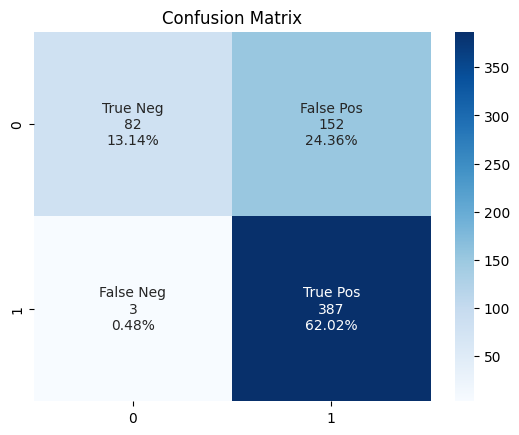

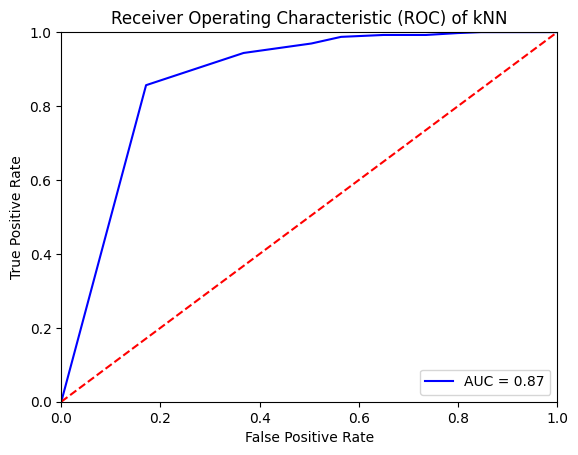

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.35      0.51       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624



In [36]:
#making an instance of algorithm
knn = KNeighborsClassifier(n_neighbors=10)

#fitting using x_train and y_train
knn.fit(x_train, y_train)

#scoring
print('KNN accuracy score is: ' + str(knn.score(x_test, y_test)))

# Test the final model on the test data
y_pred_test = knn.predict(x_test)

# Compute the probabilities of belonging to the positive class
y_score_test = knn.predict_proba(x_test)

# Compute the false positive rate (fpr), true positive rate (tpr) and the threshold
fpr, tpr, threshold = roc_curve(y_test, y_score_test[:, 1])

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

cm_test = confusion_matrix(y_test, y_pred_test)

cr_test = classification_report(y_test, y_pred_test)

showConfusionMatrix(cm_test)
showRocCurve(fpr, tpr, roc_auc)
print("Classification report:\n", cr_test)